# Demo 04 — Implied Volatility

This notebook demonstrates how to compute **Black–Scholes implied volatility (IV)** by **inverting** a pricing model:

- **Core usage (what you’ll do in practice):** call `IV_solver(p_guess, mkt_price, ...)`
- **One price → one IV:** a single “golden” inversion sanity check
- **IV curve across strikes (“smile”):** repeat the inversion across a strike grid (using synthetic prices)
- **When IV fails:** no-arbitrage bounds and bracketing
- **Regression checks:** a small suite of published Black–Scholes benchmarks

> In real markets you invert **observed prices** (often mid = (bid + ask)/2).  
> In this demo we generate **synthetic** prices so we can validate the solver end-to-end.

---

## Imports

We keep the notebook light by importing the reusable diagnostics helpers.


In [20]:
from dataclasses import replace

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from option_pricing import MarketData, OptionSpec, OptionType, PricingInputs, bs_price

# Diagnostics helpers (optional convenience for sweeps + QA)
from option_pricing.diagnostics.iv_benchmarks import (
    plot_iv_smile,
    run_bs_iv_benchmarks,
    run_synthetic_iv_smile,
    single_iv_recovery_from_template,
)
from option_pricing.numerics.root_finding import bracketed_newton
from option_pricing.vol.implied_vol import IV_solver


## Setup

We fix a single market configuration `(S, r, q, τ)` and create a template option `p_call`.  
All pricing and IV inversions below reuse this setup so results are comparable.

---

In [21]:
S, r, q, tau = 100.0, 0.05, 0.0, 1.0

market = MarketData(spot=S, rate=r, dividend_yield=q)

# A template call we will reuse (expiry is absolute time; with t=0, tau = expiry)
spec_call = OptionSpec(kind=OptionType.CALL, strike=100.0, expiry=tau)
p_call = PricingInputs(spec=spec_call, market=market, sigma=0.25, t=0.0)

p_call


PricingInputs(spec=OptionSpec(kind=<OptionType.CALL: 'call'>, strike=100.0, expiry=1.0), market=MarketData(spot=100.0, rate=0.05, dividend_yield=0.0), sigma=0.25, t=0.0)

## Benchmark: one price → implied vol (direct `IV_solver`)

We first demonstrate the **actual API call** you’ll use:

1) choose a “true” volatility `sigma_true`  
2) compute a synthetic market price `mkt_price = bs_price(p_true)`  
3) recover `iv` by calling `IV_solver` starting from a guess `sigma_guess`

Because the market price is generated by the **same model** we invert, recovery should be essentially exact (up to numerical tolerances).

---

In [22]:
sigma_true = 0.35

# Synthetic "market" price generated from the same model (BS)
p_true = replace(p_call, sigma=sigma_true)
mkt_price = bs_price(p_true)

# Invert that price to recover IV
p_guess = replace(p_call, sigma=0.20)
iv = IV_solver(
    p_guess,
    mkt_price,
    root_method=bracketed_newton,
    sigma0=p_guess.sigma,
    sigma_lo=1e-8,
    sigma_hi=5.0,
)

abs_err = abs(iv - sigma_true)
print("mkt_price:", mkt_price)
print("implied_vol:", iv)
print("abs_error:", abs_err)

# We generated the market price from the same BS model, so recovery should be ~ machine precision.
assert abs_err < 1e-10


mkt_price: 16.12842888157588
implied_vol: 0.3499999999999999
abs_error: 5.551115123125783e-17


## Optional convenience wrapper

For repeated diagnostics and clean notebooks, we also provide `single_iv_recovery_from_template(...)`, which performs the same steps as above but returns a tidy one-row DataFrame.

This is a helper — the underlying computation is still `IV_solver(...)`.

---

In [23]:
df_one = single_iv_recovery_from_template(
    p_call,
    sigma_true=sigma_true,
    sigma_guess=0.20,
    root_method=bracketed_newton,
    sigma_lo=1e-8,
    sigma_hi=5.0,
)

df_one


,sigma_true,sigma_guess,implied_vol,abs_error,mkt_price
0,0.35,0.2,0.35,5.551115e-17,16.128429


## Synthetic smile (sweep strikes)

To *see* a smile, the prices must **embed** a smile.

We define a strike-dependent “true vol” function `true_vol(K)` and then:

- generate a synthetic “market” price at each strike using `bs_price` with `sigma_true(K)`
- recover implied vol at each strike by calling `IV_solver`

This produces two curves:
- **True σ(K)** used to generate prices
- **Recovered IV(K)** from inversion

They should match closely if the implementation is correct.

---

In [24]:
def true_vol(K: float) -> float:
    x = np.log(K / S)
    return 0.20 - 0.10 * x + 0.25 * (x ** 2)

df_smile = run_synthetic_iv_smile(
    S=S, r=r, q=q, tau=tau,
    kind=OptionType.CALL,
    K_min=60.0, K_max=160.0, n=51,
    true_vol_fn=true_vol,
    sigma_guess=0.25,
    root_method=bracketed_newton,
    sigma_lo=1e-8,
    sigma_hi=5.0,
    drop_failed=False,
)

df_smile.head()


,K,log_moneyness,sigma_true,mkt_price,implied_vol,abs_error,ok
0,60.0,-0.510826,0.316318,43.287825,0.316318,9.197088e-13,True
1,62.0,-0.478036,0.304933,41.416629,0.304933,5.551115e-17,True
2,64.0,-0.446287,0.294422,39.552845,0.294422,1.054712e-15,True
3,66.0,-0.415515,0.284715,37.697773,0.284715,8.421597e-13,True
4,68.0,-0.385662,0.275750,35.852997,0.275750,2.220446e-16,True


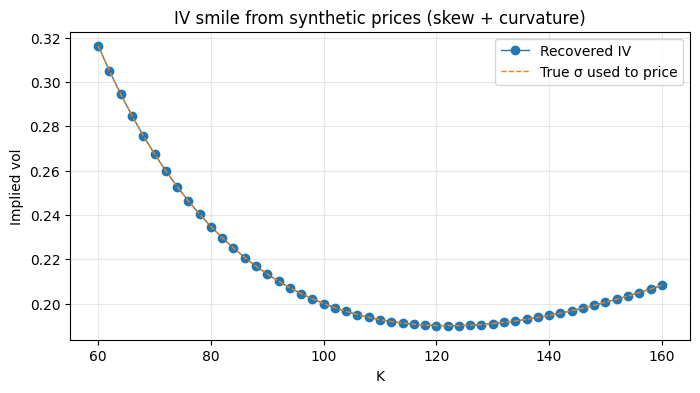

In [15]:
plot_iv_smile(
    df_smile,
    x="K",
    title="IV smile from synthetic prices (skew + curvature)",
)


## Numerical sanity: inversion error across strikes

We plot the error `IV(K) - sigma_true(K)` to confirm the recovered vols match the generating vols across the whole strike grid.

If the error grows in the wings (deep ITM/OTM), it is often due to **small vega** (the inversion becomes ill-conditioned).

---


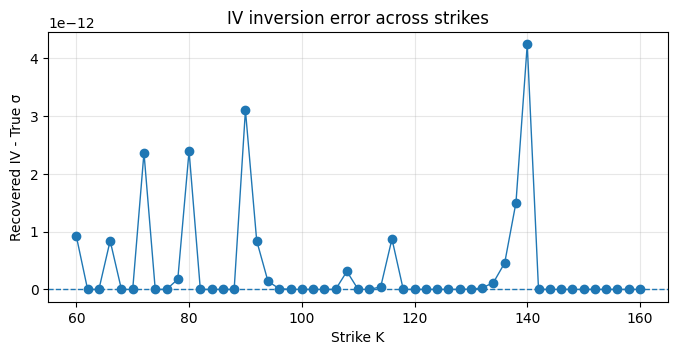

max abs error: 4.241190731946176e-12


In [16]:
# Numerical sanity: recovered IV should match sigma_true(K) very closely.
plt.figure(figsize=(8, 3.5))
plt.plot(df_smile["K"], df_smile["implied_vol"] - df_smile["sigma_true"], marker="o", linewidth=1)
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("Strike K")
plt.ylabel("Recovered IV - True σ")
plt.title("IV inversion error across strikes")
plt.grid(True, alpha=0.3)
plt.show()

print("max abs error:", float(np.nanmax(np.abs(df_smile["implied_vol"] - df_smile["sigma_true"]))))


## No-arbitrage bounds (why IV may not exist)

Implied volatility only exists if the market price is **arbitrage-free**.

For calls (with continuous dividend yield `q`), the price must satisfy:

- lower bound: `max(0, S·exp(-qτ) - K·exp(-rτ))`
- upper bound: `S·exp(-qτ)`

If a price lies outside these bounds, no volatility can make Black–Scholes match it, and root finding will fail (typically “root not bracketed”).

---

In [ ]:
# Example: no-arbitrage bounds across strikes (call)
disc_r = np.exp(-r * tau)
disc_q = np.exp(-q * tau)

K_grid = np.linspace(60, 160, 6)
bounds = []
for K in K_grid:
    lo = max(0.0, S * disc_q - float(K) * disc_r)
    hi = S * disc_q
    bounds.append((float(K), lo, hi))

pd.DataFrame(bounds, columns=["K", "call_lb", "call_ub"])


,K,call_lb,call_ub
0,60.0,42.926235,100.0
1,80.0,23.901646,100.0
2,100.0,4.877058,100.0
3,120.0,0.000000,100.0
4,140.0,0.000000,100.0
5,160.0,0.000000,100.0


## Regression: published Black–Scholes benchmarks

Finally, we run a small suite of “golden” benchmarks that check:

1) `bs_price` matches published reference prices (within tolerance)  
2) `IV_solver` recovers the reference `sigma_true` from those prices

Published prices are often rounded, so IV recovery tolerances should be realistic (often `1e-4` to `1e-3` depending on rounding and solver tolerances).

In [27]:

df_bench = run_bs_iv_benchmarks(
    price_tol=5e-4,
    iv_tol=5e-4,
    sigma_lo=1e-8,
    sigma_hi=5.0,
    save_csv_path=None,
    strict=False,
)

df_bench


,benchmark,kind,S,K,r,q,tau,sigma_true,sigma_guess,mkt_price_published,...,price_ok,price_error,implied_vol,iv_abs_error,iv_ok,iv_error,price_tol,iv_tol,sigma_lo,sigma_hi
0,ATM no-div,call,100.0,100.0,0.05,0.0,1.00,0.2,0.3,10.450600,...,True,,0.200000,4.377944e-07,True,,0.0005,0.0005,1.000000e-08,5.0
1,ATM no-div,put,100.0,100.0,0.05,0.0,1.00,0.2,0.3,5.573520,...,True,,0.200000,1.604907e-07,True,,0.0005,0.0005,1.000000e-08,5.0
2,ITM 3M,call,100.0,95.0,0.01,0.0,0.25,0.5,0.3,12.527900,...,True,,0.499999,1.242581e-06,True,,0.0005,0.0005,1.000000e-08,5.0
3,Hull-style,call,42.0,40.0,0.10,0.0,0.50,0.2,0.3,4.759422,...,True,,0.200000,3.230055e-12,True,,0.0005,0.0005,1.000000e-08,5.0
4,Hull-style,put,42.0,40.0,0.10,0.0,0.50,0.2,0.3,0.808599,...,True,,0.200000,1.079692e-14,True,,0.0005,0.0005,1.000000e-08,5.0
